### import

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch_optimizer import RAdam
from torch_optimizer import AdamP
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import wandb
import os
import sys
from omegaconf import OmegaConf # configuration 관리
from omegaconf import DictConfig

In [2]:
project_root = "C:/Users/rlduf/Desktop/Github/DeepLearning"
sys.path.append(project_root)
data_root = os.path.join(os.getcwd(), "data")

In [3]:
from data_utils import dataset_split

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]
)
fashion_mnist_dataset = FashionMNIST(data_root, download=True, train=True, transform=transform)

### Dataloader

In [6]:
datasets = dataset_split(fashion_mnist_dataset, split=[0.9, 0.1])

train_dataset = datasets["train"]
val_dataset = datasets["val"]

train_batch_size = 100
val_batch_size = 10

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=1
)

### CNN model

In [7]:
# 모델의 configuration을 정의
# 추후에 configuration의 수정과 tuning이 쉬움
_cnn_cfg_dict: dict = {
    "layer_1": {
        "conv2d_in_channels": 1,
        "conv2d_out_channels": 32,
        "conv2d_kernel_size": 3,
        "conv2d_padding": 1,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 2,
    },
    "layer_2": {
        "conv2d_in_channels": 32,
        "conv2d_out_channels": 64,
        "conv2d_kernel_size": 3,
        "conv2d_padding": 0,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 1,
    },
    "fc_1": {
        "in_features": 7744, #  수정 필요!
        "out_features": 512,
    },
    "fc_2": {
        "in_features": 512,
        "out_features": 128,        
    },
    "fc_3": {
        "in_features": 128,
        "out_features": 10,
    },
    "dropout_prob": 0.25,
}
_cnn_cfg = OmegaConf.create(_cnn_cfg_dict) # configuration 생성
print(OmegaConf.to_yaml(_cnn_cfg))

layer_1:
  conv2d_in_channels: 1
  conv2d_out_channels: 32
  conv2d_kernel_size: 3
  conv2d_padding: 1
  maxpool2d_kernel_size: 2
  maxpool2d_stride: 2
layer_2:
  conv2d_in_channels: 32
  conv2d_out_channels: 64
  conv2d_kernel_size: 3
  conv2d_padding: 0
  maxpool2d_kernel_size: 2
  maxpool2d_stride: 1
fc_1:
  in_features: 7744
  out_features: 512
fc_2:
  in_features: 512
  out_features: 128
fc_3:
  in_features: 128
  out_features: 10
dropout_prob: 0.25



In [9]:
class CNN(nn.Module):
    def __init__(self, cfg: DictConfig = _cnn_cfg):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_1.conv2d_in_channels,
                out_channels=cfg.layer_1.conv2d_out_channels,
                kernel_size=cfg.layer_1.conv2d_kernel_size,
                padding=cfg.layer_1.conv2d_padding
            ),
            nn.BatchNorm2d(cfg.layer_1.conv2d_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=cfg.layer_1.maxpool2d_kernel_size,
                stride=cfg.layer_1.maxpool2d_stride
            )
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_2.conv2d_in_channels,
                out_channels=cfg.layer_2.conv2d_out_channels,
                kernel_size=cfg.layer_2.conv2d_kernel_size,
                padding=cfg.layer_2.conv2d_padding
            ),
            nn.BatchNorm2d(cfg.layer_2.conv2d_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=cfg.layer_2.maxpool2d_kernel_size,
                stride=cfg.layer_2.maxpool2d_stride
            )
        )
        self.fc1 = nn.Linear(
            in_features=cfg.fc_1.in_features,
            out_features=cfg.fc_1.out_features,
        )
        self.fc2 = nn.Linear(
            in_features=cfg.fc_2.in_features,
            out_features=cfg.fc_2.out_features,
        )
        self.fc3 = nn.Linear(
            in_features=cfg.fc_3.in_features,
            out_features=cfg.fc_3.out_features,
        )
        self.dropout = nn.Dropout2d(cfg.dropout_prob)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # batchsize를 제외하고 나머지는 flatten
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [10]:
CNN()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=7744, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout2d(p=0.25, inplace=False)
)

### Learning Rate Scheduler 



In [13]:
# Warmup Scheduler
class WarmupLR(optim.lr_scheduler.LambdaLR):

    def __init__(
        self,
        optimizer: optim.Optimizer,
        warmup_end_steps: int,
        last_epoch: int = -1,
    ):
        
        def wramup_fn(step: int):
            if step < warmup_end_steps:
                return float(step) / float(max(warmup_end_steps, 1))
            return 1.0
        
        super().__init__(optimizer, wramup_fn, last_epoch)

### Loss function, Optimizer, Wandb Logger

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# define model.
# model = MLP(28*28, 128, 64, 10)
# model = MLPWithDropout(28*28, 128, 64, 10, dropout_prob=0.3)
model = CNN(cfg=_cnn_cfg).to(device)
model_name = type(model).__name__

# define loss
loss_function = nn.CrossEntropyLoss()

# define optimizer
lr = 1e-3
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#optimizer = RAdam(model.parameters(), lr=lr)
#optimizer = AdamP(model.parameters(), lr=lr)
optimizer_name = type(optimizer).__name__

# define scheduler
scheduler = WarmupLR(optimizer, 1500)
scheduler_name = type(scheduler).__name__ if scheduler is not None else "no"

max_epoch = 30

# define model path
log_dir = f"{model_name}-{optimizer_name}-{lr}-{scheduler_name}"
log_model_path = os.path.join(log_dir, 'models')
os.makedirs(log_model_path, exist_ok=True)

# define wandb
project_name = "fashion_mnist"
run_tags = [project_name]
wandb.init(
    project=project_name,
    name=log_dir,
    tags=run_tags,
    config={"lr": lr, "model_name": model_name, "optimizer_name": optimizer_name, "scheduler_name": scheduler_name},
    reinit=True,
)


### Early Stopping callback Object Class

In [26]:
# With some modifications, source is from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.ckpt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.ckpt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path) # model 파라미터 저장
        torch.save(model, self.path) # 모델 전체 저장
        print('Save new model!!')
        self.val_loss_min = val_loss

In [ ]:
# define EarlyStopping.
early_stopper = EarlyStopping(
    patience=3, verbose=True, path=os.path.join(log_model_path, "model.ckpt")
)

# do train with validation.
train_step = 0
for epoch in range(1, max_epoch+1):
    # valid step
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        model.eval()

        for val_batch_idx, (val_images, val_labels) in enumerate(
            tqdm(val_dataloader, position=0, leave=True, desc="validation")
        ):
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            # forward
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)
            
            # loss & acc
            val_loss += loss_function(val_outputs, val_labels) / val_outputs.shape[0]
            val_corrects += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]
    
    # valid step logging
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_acc = val_corrects / len(val_dataloader)
    
    print(
        f"{epoch} epoch, {train_step} step: val_loss: {val_epoch_loss}, val_acc: {val_epoch_acc}"
    )

    # wandb log
    wandb.log({
        "Loss/val": val_epoch_loss,
        "Acc/val": val_epoch_acc,
        "Images/val": wandb.Image(val_images),
        "Outputs/val": wandb.Histogram(val_outputs.detach().cpu().numpy()),
        "Preds/val": wandb.Histogram(val_preds.detach().cpu().numpy()),
        "Labels/val": wandb.Histogram(val_labels.data.detach().cpu().numpy()),
    }, step=train_step)

    # check model early stopping point & save model if the model reached the best performance.
    early_stopper(val_epoch_loss, model)
    if early_stopper.early_stop:
        break
    
    # train step
    current_loss = 0
    current_corrects = 0
    model.train()

    for batch_idx, (images, labels) in enumerate(
         tqdm(train_dataloader, position=0, leave=True, desc="training")
    ):
        images, labels = images.to(device), labels.to(device)

        current_loss = 0.0
        current_corrects = 0

        # Forward
        # get predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # get loss (Loss 계산)
        loss = loss_function(outputs, labels)

        # Backpropagation
        # optimizer 초기화 (zero화)
        optimizer.zero_grad()

        # Perform backward pass
        loss.backward()

        # Perform Optimization
        optimizer.step()

        # Perform LR scheduler Work
        if scheduler is not None:
            scheduler.step()

        current_loss += loss.item()
        current_corrects += torch.sum(preds == labels.data)

        if train_step % 100 == 0:
            train_loss = current_loss / 100
            train_acc = current_corrects / 100

            print(
                f"{train_step}: train_loss: {train_loss}, train_acc: {train_acc}"
            )

            # wandb log
            wandb.log({
                "Loss/train": train_loss,
                "Acc/train": train_acc,
                "Images/train": wandb.Image(images),
                "Outputs/train": wandb.Histogram(outputs.detach().cpu().numpy()),
                "Preds/train": wandb.Histogram(preds.detach().cpu().numpy()),
                "Labels/train": wandb.Histogram(labels.data.detach().cpu().numpy()),
                "Learning Rate": scheduler.get_last_lr()[0]
            }, step=train_step)

            current_loss = 0
            current_corrects = 0

        train_step += 1
        
    print('\n')

In [39]:
# load model
model_path = 'model.ckpt'
loaded_model = torch.load(os.path.join(log_model_path, model_path)).to(device)
loaded_model.eval()
print(loaded_model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=7744, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout2d(p=0.25, inplace=False)
)


In [40]:
def softmax(x, axis=0):
    "numpy softmax"
    max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x, axis=axis, keepdims=True)
    f_x = e_x / sum
    return f_x

In [41]:
test_batch_size = 128
test_dataset = FashionMNIST(data_root, download=True, train=False, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=1)

test_labels_list = []
test_preds_list = []
test_outputs_list = []
for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position=0, leave=True, desc="testing")):
    # forward
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    test_outputs = loaded_model(test_images)
    _, test_preds = torch.max(test_outputs, 1)

    final_outs = softmax(test_outputs.detach().cpu().numpy(), axis=1)
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.detach().cpu().numpy())
    test_labels_list.extend(test_labels.detach().cpu().numpy())

test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f"\nacc: {np.mean(test_preds_list == test_labels_list)*100}%")

testing: 100%|██████████| 79/79 [00:02<00:00, 27.82it/s]


acc: 89.46%


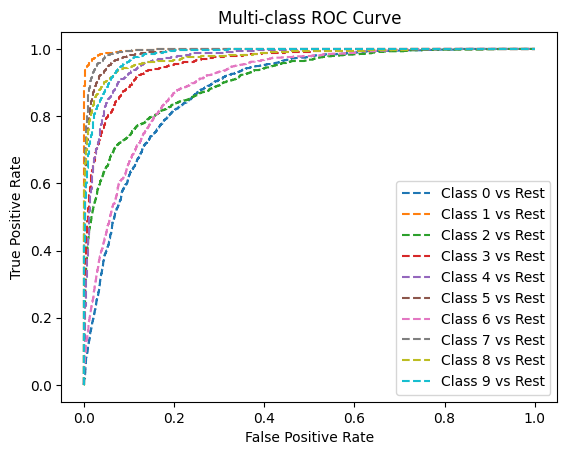

auc_score 0.9562889666666666


In [34]:
# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr = {}
tpr = {}
thresh = {}
n_class = 10

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:, i], pos_label=i)

# plot.
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle="--", label=f"Class {i} vs Rest")
plt.title("Multi-class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.show()

print("auc_score", roc_auc_score(test_labels_list, test_outputs_list, multi_class="ovo", average="macro"))